# Bibliotecas

In [121]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

import keras.backend as K
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, BatchNormalization
from keras.utils.vis_utils import plot_model
from keras.utils.np_utils import  to_categorical
from keras.callbacks import ModelCheckpoint

from quickda.explore_data import explore

# Ignorar Avisos desnecessários
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
#print(tf.config.experimental.list_physical_devices())

Num GPUs Available:  1


# Funções Auxiliares

In [3]:
# Funções Auxiliares
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training Accuracy')
    plt.plot(x, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and validation Accuracy')
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
def min_max(serie):
    min = serie.min()
    max = serie.max()
    
    return serie.apply(lambda x: (x-min)/(max-min))

class ModelCheckpoint_tweaked(tf.keras.callbacks.ModelCheckpoint):
    def __init__(self,
                   filepath,
                   monitor='val_loss',
                   verbose=0,
                   save_best_only=False,
                   save_weights_only=False,
                   mode='auto',
                   save_freq='epoch',
                   options=None,
                   **kwargs):
        
        #Change tf_utils source package.
        from tensorflow.python.keras.utils import tf_utils
        
        super(ModelCheckpoint_tweaked, self).__init__(filepath,
                   monitor,
                   verbose,
                   save_best_only,
                   save_weights_only,
                   mode,
                   save_freq,
                   options,
                   **kwargs)
        
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
        
    return f1_val

# Carregando e Analisando os dados

In [4]:
df = pd.read_csv("./data/DadosSpotify.csv")

In [5]:
print(f"Número de variáveis = {len(df.columns)}")

Número de variáveis = 17


## Amostra dos Dados

In [6]:
df.head()

,id,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future
1,1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino
2,2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future
3,3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House
4,4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys


## Conferindo se temos dados nulos, qual o formato das variáveis e quais podem ser numéricas ou categóricas

In [7]:
explore(df)

,dtypes,count,null_sum,null_pct,nunique,min,25%,50%,75%,max,mean,median,std,skew
acousticness,float64,2017,0,0.0,1394,0.000003,0.00963,0.0633,0.265,0.995,0.18759,0.0633,0.259989,1.658393
artist,object,2017,0,0.0,1343,!!!,-,-,-,플랫핏 Flat Feet,-,-,-,-
danceability,float64,2017,0,0.0,632,0.122,0.514,0.631,0.738,0.984,0.618422,0.631,0.161029,-0.41961
duration_ms,int64,2017,0,0.0,1921,16042,200015.0,229261.0,270333.0,1004627,246306.197323,229261.0,81981.814219,2.499012
energy,float64,2017,0,0.0,719,0.0148,0.563,0.715,0.846,0.998,0.681577,0.715,0.210273,-0.91301
id,int64,2017,0,0.0,2017,0,504.0,1008.0,1512.0,2016,1008.0,1008.0,582.402066,0.0
instrumentalness,float64,2017,0,0.0,1107,0.0,0.0,0.000076,0.054,0.976,0.133286,0.000076,0.273162,1.952755
key,int64,2017,0,0.0,12,0,2.0,6.0,9.0,11,5.342588,6.0,3.64824,-0.00936
liveness,float64,2017,0,0.0,793,0.0188,0.0923,0.127,0.247,0.969,0.190844,0.127,0.155453,1.952703
loudness,float64,2017,0,0.0,1808,-33.097,-8.394,-6.248,-4.746,-0.307,-7.085624,-6.248,3.761684,-2.226556


## Retirando dados irrelevantes

In [8]:
df = df.drop(['id', 'song_title', 'artist'], axis=1)

In [119]:
explore(df)

,dtypes,count,null_sum,null_pct,nunique,min,25%,50%,75%,max,mean,median,std,skew
acousticness,float64,2017,0,0.0,1394,0.000,0.010,0.063,0.265,0.995,0.188,0.063,0.260,1.658
danceability,float64,2017,0,0.0,632,0.122,0.514,0.631,0.738,0.984,0.618,0.631,0.161,-0.420
duration_ms,int64,2017,0,0.0,1921,16042.000,200015.000,229261.000,270333.000,1004627.000,246306.197,229261.000,81981.814,2.499
energy,float64,2017,0,0.0,719,0.015,0.563,0.715,0.846,0.998,0.682,0.715,0.210,-0.913
instrumentalness,float64,2017,0,0.0,1107,0.000,0.000,0.000,0.054,0.976,0.133,0.000,0.273,1.953
key,int64,2017,0,0.0,12,0.000,2.000,6.000,9.000,11.000,5.343,6.000,3.648,-0.009
liveness,float64,2017,0,0.0,793,0.019,0.092,0.127,0.247,0.969,0.191,0.127,0.155,1.953
loudness,float64,2017,0,0.0,1808,-33.097,-8.394,-6.248,-4.746,-0.307,-7.086,-6.248,3.762,-2.227
mode,int64,2017,0,0.0,2,0.000,0.000,1.000,1.000,1.000,0.612,1.000,0.487,-0.461
speechiness,float64,2017,0,0.0,792,0.023,0.038,0.055,0.108,0.816,0.093,0.055,0.090,2.310


## Distribuição das respostas

### Abaixo verificamos que a distribuição das respostas é perfeita.

In [9]:
round(df.groupby('target').count().key / df.shape[0] * 100, 2)

target
0    49.43
1    50.57
Name: key, dtype: float64

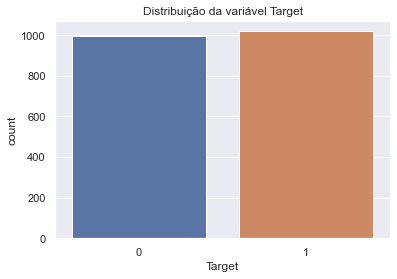

In [10]:
sns.countplot(df.target)
plt.title('Distribuição da variável Target')
plt.xlabel('Target')
plt.xticks(ticks=range(0,2), labels=['0', '1'])
plt.show()

## Análise de correlação

In [11]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target
acousticness,1.00,-0.18,0.07,-0.65,0.14,-0.08,-0.12,-0.56,0.07,-0.10,-0.13,-0.19,-0.15,-0.13
danceability,-0.18,1.00,0.00,0.04,-0.13,0.02,-0.13,0.10,-0.05,0.14,-0.14,0.13,0.44,0.18
duration_ms,0.07,0.00,1.00,-0.14,0.31,0.02,0.02,-0.27,-0.07,-0.08,-0.08,-0.04,-0.12,0.15
energy,-0.65,0.04,-0.14,1.00,-0.12,0.07,0.22,0.76,-0.07,0.09,0.17,0.18,0.28,0.04
instrumentalness,0.14,-0.13,0.31,-0.12,1.00,-0.01,0.00,-0.35,-0.03,-0.16,0.00,-0.07,-0.19,0.15
key,-0.08,0.02,0.02,0.07,-0.01,1.00,0.05,0.05,-0.20,0.02,0.04,0.02,0.03,0.03
liveness,-0.12,-0.13,0.02,0.22,0.00,0.05,1.00,0.16,-0.02,0.09,0.01,0.02,-0.05,0.03
loudness,-0.56,0.10,-0.27,0.76,-0.35,0.05,0.16,1.00,-0.04,0.09,0.16,0.14,0.20,-0.07
mode,0.07,-0.05,-0.07,-0.07,-0.03,-0.20,-0.02,-0.04,1.00,-0.05,-0.06,-0.04,-0.03,-0.07
speechiness,-0.10,0.14,-0.08,0.09,-0.16,0.02,0.09,0.09,-0.05,1.00,0.11,0.11,0.05,0.15


In [12]:
#df = df.drop("energy", axis=1)
X = df.iloc[:, 0:13].copy()
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)
X_scaled.shape

(2017, 13)

In [13]:
fig = px.box(X_scaled)
fig.show()

In [14]:
X = X_scaled
X.to_numpy
num_features = X.shape[1]
X.shape

(2017, 13)

In [15]:
y = df.target.to_numpy()
y.shape

(2017,)

## Após diversas tentaivas manuais de escolher as melhores variáveis, resolvemos usar um método do Keras para selecionar as 8 melhores levando em consideração a métrica F1 Score.

In [16]:
selector = SelectKBest(f_classif, k=8)
selected_features = selector.fit_transform(X, y)

In [17]:
X = selected_features
num_features = X.shape[1]
X.shape

(2017, 8)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
X_train.shape

(1613, 8)

In [20]:
y_train.shape

(1613,)

<AxesSubplot:ylabel='count'>

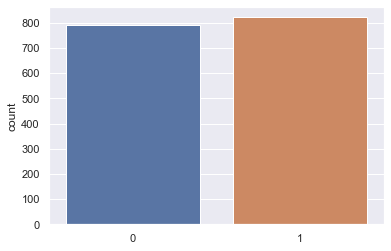

In [21]:
sns.countplot(y_train)

<AxesSubplot:ylabel='count'>

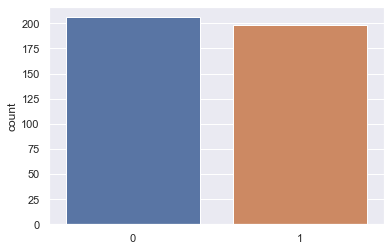

In [22]:
sns.countplot(y_test)

# Modelo de MLP

In [122]:
## Criando o modelo
model = Sequential()
model.add(Dense(128, input_dim=num_features, activation='tanh'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='tanh'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1 , activation='sigmoid'))
print(model.summary())

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 128)               1152      
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 128)               16512     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout_17 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 1)               

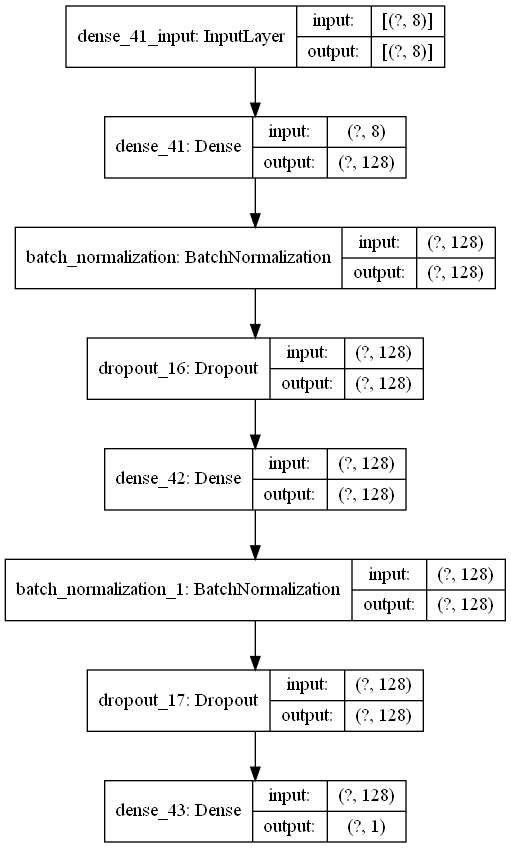

In [123]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [124]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

In [125]:
%%time
checkpointer = ModelCheckpoint(filepath='./modelo_mlp_ex5_1.hdf5', verbose=1, save_best_only=True, monitor='val_accuracy')

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1500, batch_size=128, verbose=1, callbacks=[checkpointer])
#history = model.fit(X_train, y_train, validation_split=0.2, epochs=600, batch_size=128, verbose=0, callbacks=[checkpointer])

Wall time: 2min 7s


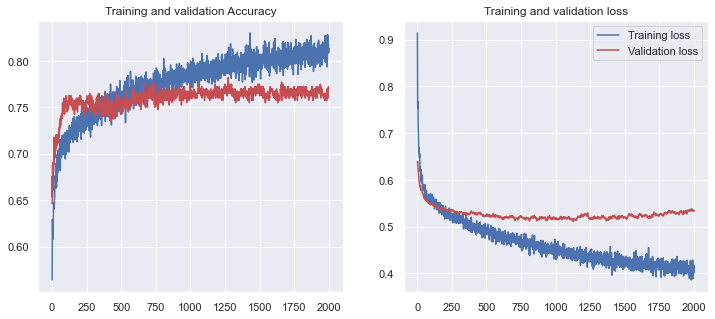

In [126]:
plot_history(history)

## Apresentando a Acurácia final do Treino, carregando o melhor modelo salvo e apresentando a Acurácia do Teste

In [127]:
scores = model.evaluate(X_train, y_train)
print()
print(f"Acuracia do Treino: {round(scores[1]*100,2)}%")

51/51 [==============================] - 0s 2ms/step - loss: 0.2798 - accuracy: 0.8890

Acuracia do Treino: 88.9%


In [128]:
model = load_model("./modelo_mlp_ex5_1.hdf5")

In [129]:
scores = model.evaluate(X_test, y_test)
print()
print(f"Acuracia do Teste: {round(scores[1]*100,2)}%")

13/13 [==============================] - 0s 2ms/step - loss: 0.5166 - accuracy: 0.7822

Acuracia do Teste: 78.22%


## Banco de Dados difícil de tratar. Conseguimos uma Acurácia de 77 % após diversos testes. Acreditamos que seria necessário tratar ainda mais os dados iniciais, mas definitivamente precisamos de mais dados para melhorar este modelo.